In [22]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# import tensorflow datasets
data = tf.data.TFRecordDataset('../../data/external/EuroSAT/eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001')

labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

2022-12-29 10:02:33.433546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# inspect the first record
for raw_record in data.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "SeaLake_2401.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\027\000\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\002\n\377\304\000(\020\

In [5]:
# see length of dataset
print(len(list(data)))

27000


In [6]:
# print size of each of the 10 classes
for label in labels:
    count = 0
    for raw_record in data:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        if example.features.feature['label'].int64_list.value[0] == labels.index(label):
            count += 1
    print(label, count)

AnnualCrop 3000
Forest 3000
HerbaceousVegetation 3000


KeyboardInterrupt: 

SeaLake
(64, 64, 3)


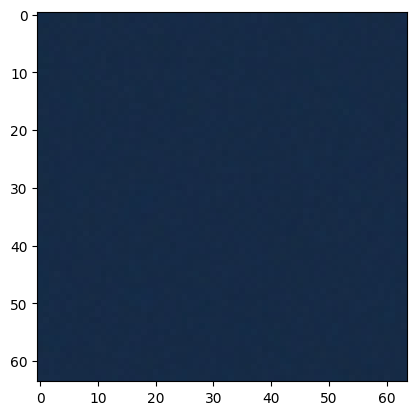

PermanentCrop
(64, 64, 3)


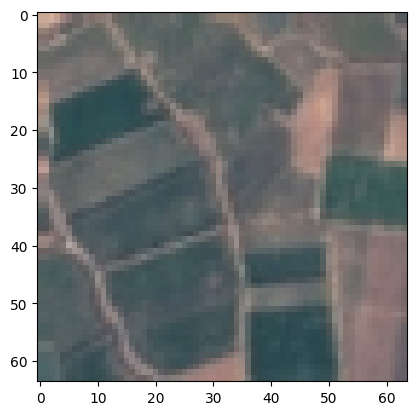

SeaLake
(64, 64, 3)


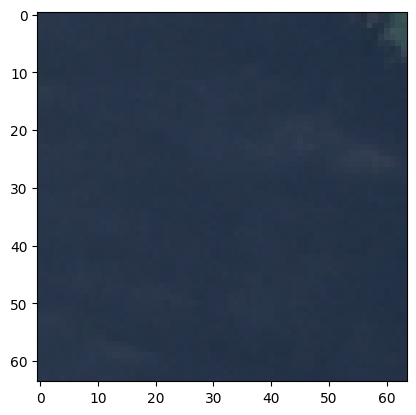

Industrial
(64, 64, 3)


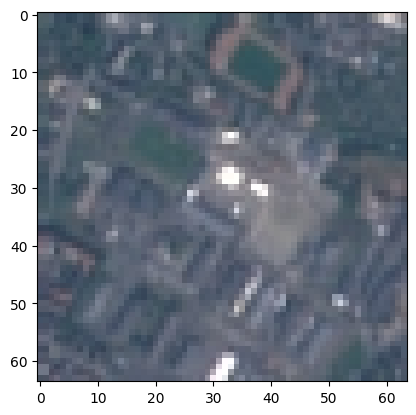

Pasture
(64, 64, 3)


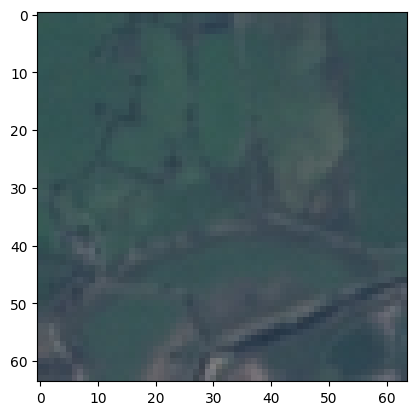

In [9]:
# parse single image from tfrecord
def parse_image(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed_features['image'])

    label = tf.cast(parsed_features['label'], tf.int32)
    return image, label

def resize_image(image, label):
    image = tf.image.resize(image, [64, 64])
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

def split_into_batches(dataset, batch_size):
    return dataset.cache().shuffle(27000).batch(batch_size)

def split_into_train_test_validation(dataset, batch_size):
    train_size = int(0.5 * 27000)
    validation_set = int(0.3 * 27000)
    test_size = int(0.2 * 27000)
    train_dataset = dataset.take(train_size).cache().shuffle(train_size).batch(batch_size)
    validation_dataset = dataset.skip(train_size).take(validation_set).cache().shuffle(validation_set).batch(batch_size)
    test_dataset = dataset.skip(train_size).skip(validation_set).take(test_size).cache().shuffle(test_size).batch(batch_size)
    return train_dataset, validation_dataset, test_dataset


def sample_images(dataset, batch_size, num_batches=500):
    return dataset.take(num_batches*batch_size).cache().batch(batch_size)

# parse first image from data
parsed_image_dataset = data.map(parse_image)
parsed_image_dataset = parsed_image_dataset.map(resize_image)

for image, label in parsed_image_dataset.take(5):
  image_raw = image.numpy()
  print(labels[label.numpy()])
  print(image_raw.shape)
  plt.imshow(image_raw.astype('uint8'))
  plt.show()
  plt.close()
  
parsed_image_dataset = parsed_image_dataset.map(normalize)
# split into train and test
train_dataset, validation_dataset, test_dataset = split_into_train_test_validation(parsed_image_dataset, 50)
# train_dataset = sample_images(train_dataset, 50, num_batches=1000)
# validation_dataset = sample_images(validation_dataset, 50)
# test_dataset = sample_images(test_dataset, 50)

  

In [24]:

# build CNN model
def build_model(number_of_conv2d_layers=2, number_of_filters=32, kernel_size=(3, 3), activation='relu', padding='same', pool_size=(2, 2), dropout=0.5, number_of_dense_layers=2, number_of_dense_nodes=128, dense_activation='relu', output_activation='softmax', loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    # augment data
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(1, input_shape=(64, 64, 3)),
        tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.5),
    ])

    # create number_of_conv2d_layers:
    conv2d_layers = []
    for i in range(number_of_conv2d_layers):
        conv2d_layers.append(tf.keras.layers.Conv2D(number_of_filters, kernel_size, activation=activation, padding=padding))
        conv2d_layers.append(tf.keras.layers.MaxPooling2D(pool_size))
        conv2d_layers.append(tf.keras.layers.Dropout(dropout))

    # create dense layers in for loop
    dense_layers = []
    for i in range(number_of_dense_layers):
        dense_layers.append(tf.keras.layers.Dense(number_of_dense_nodes, activation=dense_activation))
        dense_layers.append(tf.keras.layers.Dropout(dropout))
    
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.Sequential(conv2d_layers),
        tf.keras.layers.Flatten(),
        tf.keras.Sequential(dense_layers),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

# train model
model = build_model()
history = model.fit(train_dataset, epochs=50, batch_size=50, validation_data=test_dataset, callbacks=[early_stopping])
# evaluate model
model.evaluate(test_dataset, batch_size=50)

# grid search hyperpameters, save best model

# store results
results = []
# for number_of_conv2d_layers in [2, 3, 4]:
#     for number_of_filters in [32, 64, 128]:
#         for number_of_dense_layers in [2, 3, 4]:
#             for number_of_dense_nodes in [128, 256, 512]:
for number_of_conv2d_layers in [2]:
    for number_of_filters in [32]:
        for number_of_dense_layers in [2]:
            for number_of_dense_nodes in [128]:
                model = build_model(number_of_conv2d_layers=number_of_conv2d_layers, number_of_filters=number_of_filters, number_of_dense_layers=number_of_dense_layers, number_of_dense_nodes=number_of_dense_nodes)
                history = model.fit(train_dataset, epochs=50, batch_size=50, validation_data=test_dataset, callbacks=[early_stopping])
                model.evaluate(test_dataset, batch_size=50)
                results.append((number_of_conv2d_layers, number_of_filters, number_of_dense_layers, number_of_dense_nodes, history.history['val_accuracy'][-1]))
                model.save(f'./models/{number_of_conv2d_layers}_{number_of_filters}_{number_of_dense_layers}_{number_of_dense_nodes}.h5')

# store results in dataframe
results_df = pd.DataFrame(results, columns=['number_of_conv2d_layers', 'number_of_filters', 'number_of_dense_layers', 'number_of_dense_nodes', 'val_accuracy'])
results_df.sort_values(by='val_accuracy', ascending=False, inplace=True)




Epoch 1/50
270/270 [==============================] - 30s 100ms/step - loss: 2.0205 - accuracy: 0.2228 - val_loss: 1.6310 - val_accuracy: 0.3285
Epoch 2/50
270/270 [==============================] - 27s 100ms/step - loss: 1.6199 - accuracy: 0.3783 - val_loss: 1.4098 - val_accuracy: 0.4824
Epoch 3/50
270/270 [==============================] - 27s 99ms/step - loss: 1.4446 - accuracy: 0.4677 - val_loss: 1.2593 - val_accuracy: 0.5663
Epoch 4/50
 88/270 [========>.....................] - ETA: 17s - loss: 1.3782 - accuracy: 0.4843

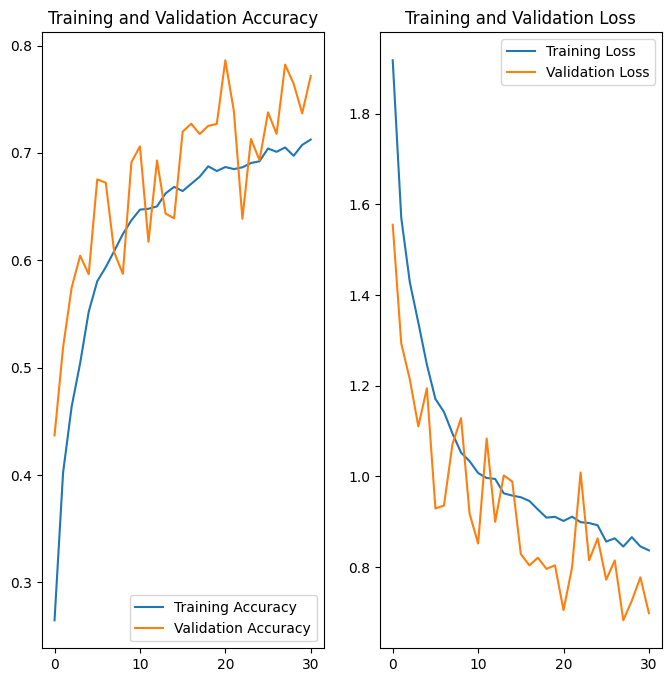

In [14]:
# plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


2/2 [==============================] - 0s 9ms/step


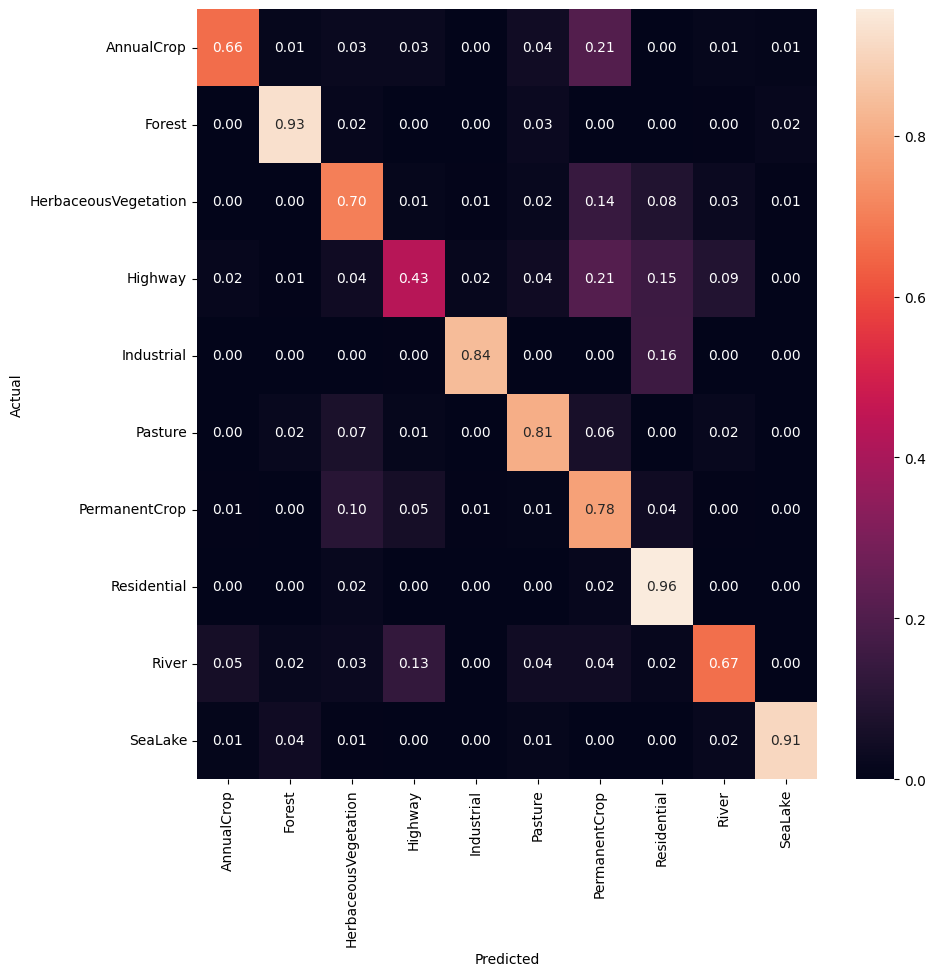

In [15]:
# evaluate in a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = []
y_pred = []
images = []
for image, label in test_dataset:
    y_true.append(label)
    y_pred.append(model.predict(image))
    images.append(image)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
image_list = np.concatenate(images)

y_pred_max = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_max)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  # plt.imshow(img[...,0], cmap=plt.cm.binary)
  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)
# change xlabel size
  plt.rcParams['xtick.labelsize'] = 10

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')



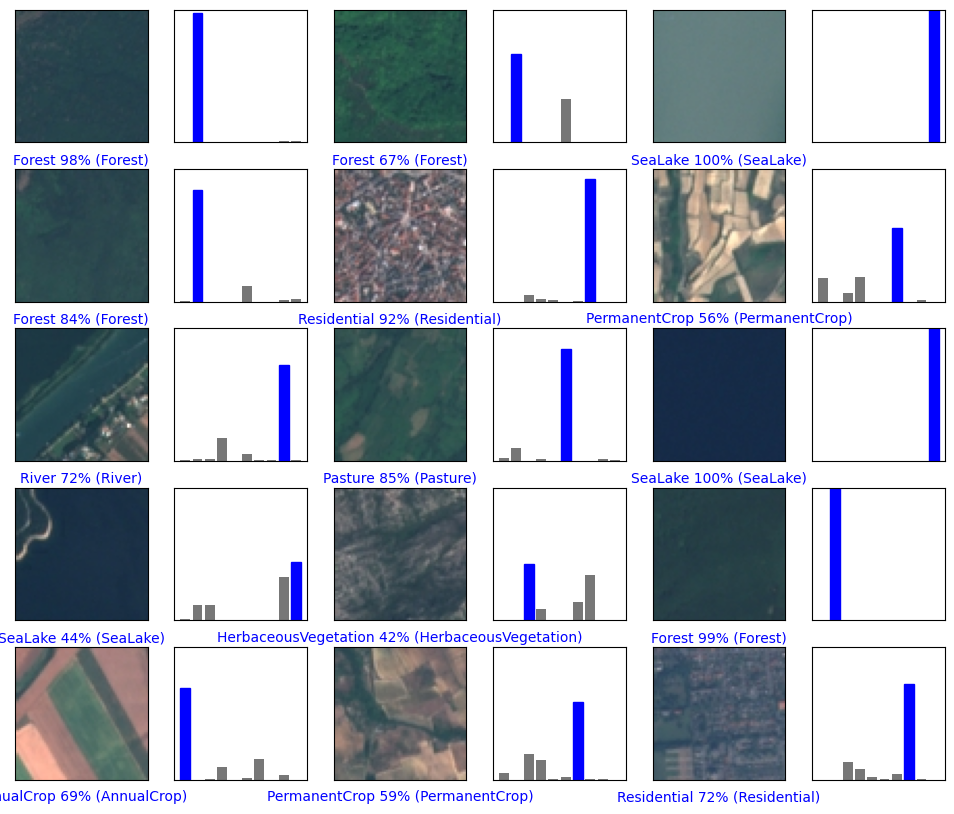

In [18]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred, y_true, image_list)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, y_pred, y_true)
plt.savefig('../../reports/figures/EuroSAT/satellite_items.png')